In [1]:
!pip install tensorflow==2.13.0 tensorflow-compression==2.13.0 tensorflow-probability==0.20.0

Reason for being yanked: TFP 0.20 should require Python 3.8+
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.8/257.8 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 69.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 45.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 61.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 70.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 18.4 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.12.2
    Uninstalling typing_extensions-4.12.2:
      Successfully uninstalled typing_extensions-4.12.2
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-esti

Import Libraries

In [2]:
import tensorflow as tf
import tensorflow_compression as tfc
import os
import sys
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

Model

In [3]:
class SemViT(tf.keras.Model):
    def __init__(self, block_types, filters, num_blocks,
                 num_symbols=512, snrdB=10, channel='AWGN'):
        '''
        block_types: (list) types of each building blocks
            'V' for ViT block, 'C' for Conv (ResNet) block
            e.g., ['C', 'C', 'V', 'V', 'C', 'C']
        filters: (list) output dimensions for each block
            e.g., [256, 256, 256, 256, 256, 256]
        num_blocks: (list) # of repetition for each block
            e.g., [1, 1, 3, 3, 1, 1]
        num_symbols: (int) # of total complex symbols sent
            e.g., 512 for 1/6 bandwidth ratio (512 / 32*32*3)
        snrdB: (int) channel snr (in dB)
        channel: (str) channel type ('Rayleigh', 'AWGN', or None)
        '''
        super().__init__()
        
        assert len(block_types) == len(filters) == len(num_blocks) == 6, \
               "length of block_types, filters, num_blocks should be 6"
        self.encoder = SemViT_Encoder(
            block_types[:3],
            filters[:3],
            num_blocks[:3],
            num_symbols
        )

        if channel == 'Rayleigh':
            self.channel = RayleighChannel(snrdB)
        elif channel == 'AWGN':
            self.channel = AWGNChannel(snrdB)
        elif channel == 'Rician':
            self.channel = RicianChannel(snrdB, k=2)
        else:
            self.channel = tf.identity

        self.decoder = SemViT_Decoder(
            block_types[3:],
            filters[3:],
            num_blocks[3:]
        )
    
    def call(self, x):
        x = self.encoder(x)
        x = self.channel(x)
        x = self.decoder(x)

        return x


class SemViT_Encoder(tf.keras.layers.Layer):
    def __init__(self, block_types, filters, num_blocks,
                 num_symbols, **kwargs):
        super().__init__()
        self.layers = [
            # 32 x 32 input
            build_blocks(0, block_types, num_blocks, filters, 32, kernel_size=9, stride=2),
            # downsampled to 16 x 16
            build_blocks(1, block_types, num_blocks, filters, 16, kernel_size=5, stride=2),
            # downsampled to 8 x 8
            build_blocks(2, block_types, num_blocks, filters, 8, kernel_size=5),
            # to constellation
            tf.keras.layers.Conv2D(
                filters=num_symbols // 8 // 8 * 2,
                # current spatial dimension is 8 x 8
                # and 2 for iq dimension
                kernel_size=1
            )
        ]


    def call(self, x):
        for sublayer in self.layers:
            x = sublayer(x)
        
        b, h, w, c = x.shape
        x = tf.reshape(x, (-1, h*w*c//2, 2))
        return x
    

    def get_config(self):
        config = super().get_config()
        return config


class SemViT_Decoder(tf.keras.layers.Layer):
    def __init__(self, block_types, filters, num_blocks,  **kwargs):
        super().__init__()
        self.layers = [
            # 8 x 8 input
            build_blocks(0, block_types, num_blocks, filters, 8, kernel_size=5),
            # upsampled to 16 x 16
            tf.keras.layers.Resizing(16, 16),
            build_blocks(1, block_types, num_blocks, filters, 16, kernel_size=5),
            # upsampled to 32 x 32
            tf.keras.layers.Resizing(32, 32),
            build_blocks(2, block_types, num_blocks, filters, 32, kernel_size=9),
            # to image
            tf.keras.layers.Conv2D(
                filters=3,
                kernel_size=1,
                activation='sigmoid'
            )
        ]


    def call(self, x):
        b, c, _ = x.shape
        x = tf.reshape(x, (-1, 8, 8, c*2//64))

        for sublayer in self.layers:
            x = sublayer(x)
        return x
    

    def get_config(self):
        config = super().get_config()
        return config


def build_blocks(layer_idx, block_types, num_blocks, filters, spatial_size, kernel_size=5, stride=1):
    assert block_types[layer_idx] in ('C', 'V'), "layer type should be either C or V"

    if block_types[layer_idx] == 'C':
        return build_conv(
            repetition=num_blocks[layer_idx],
            filter_size=filters[layer_idx],
            kernel_size=kernel_size,
            stride=stride)
    else:
        return build_vitblocks(
            repetition=num_blocks[layer_idx],
            num_heads=filters[layer_idx]//32,
            head_size=32,
            spatial_size=spatial_size,
            stride=stride)


def build_conv(repetition, filter_size, kernel_size=5, stride=1):
    x = tf.keras.Sequential()
    for i in range(repetition):
        s = stride if i == 0 else 1
        x.add(tfc.SignalConv2D(
                filter_size,
                kernel_size,
                corr=True,
                strides_down=s,
                padding="same_zeros",
                use_bias=True,
        ))
        x.add(tf.keras.layers.Lambda(lambda x: x))
        x.add(tf.keras.layers.PReLU(shared_axes=[1, 2]))
    return x


def build_vitblocks(repetition, num_heads, head_size, spatial_size, stride=1):
    x = tf.keras.Sequential()
    for i in range(repetition):
        s = stride if i == 0 else 1
        x.add(VitBlock(num_heads, head_size, spatial_size, stride=s))
        x.add(tf.keras.layers.Lambda(lambda x: x))
        
    return x


class SemViT_Encoder_Only(tf.keras.Model):
    def __init__(self, block_types, filters, num_blocks, num_symbols=512):
        super().__init__()
        
        assert len(block_types) == len(filters) == len(num_blocks) == 6, \
               "length of block_types, filters, num_blocks should be 6"
        self.encoder = SemViT_Encoder(
            block_types[:3],
            filters[:3],
            num_blocks[:3],
            num_symbols
        )
    
    def call(self, x):
        x = self.encoder(x)

        return x


class SemViT_Decoder_Only(tf.keras.Model):
    def __init__(self, block_types, filters, num_blocks, num_symbols=512):
        super().__init__()
        
        assert len(block_types) == len(filters) == len(num_blocks) == 6, \
               "length of block_types, filters, num_blocks should be 6"
        self.decoder = SemViT_Decoder(
            block_types[3:],
            filters[3:],
            num_blocks[3:]
        )
    
    def call(self, x):
        x = self.decoder(x)

        return x

class Channel_Only(tf.keras.Model):
    def __init__(self, snrdB=10, channel='AWGN'):
        super().__init__()
        if channel == 'Rayleigh':
            self.channel = RayleighChannel(snrdB)
        elif channel == 'AWGN':
            self.channel = AWGNChannel(snrdB)
        elif channel == 'Rician':
            self.channel = RicianChannel(snrdB, k=2)
        else:
            self.channel = tf.identity
    
    def call(self, x):
        x = self.channel(x)
        return x




class AWGNChannel(tf.keras.layers.Layer):
    def __init__(self, snrdB=None):
        super().__init__()
        self.snr = 10 ** (snrdB / 10) # in dB
    

    def call(self, x):
        '''
        x: inputs with shape (b, c, 2)
           where last dimension denotes in-phase and quadrature-phase elements, respectively.
        '''
        assert x.shape[2] == 2, "input shape should be (b, c, 2), where last dimension denotes i and q, respectively"
        assert len(x.shape) == 3, "input shape should be (b, c, 2)"

        i = x[:,:,0]
        q = x[:,:,1]

        # power normalization
        sig_power = tf.math.reduce_mean(i ** 2 + q ** 2)
        snr = self.snr

        n = tf.random.normal(
            tf.shape(x),
            mean=0,
            stddev=tf.math.sqrt(sig_power/(2*snr))
        )

        y = x + n
        return y
    

    def get_config(self):
        config = super().get_config()
        return config



class RayleighChannel(tf.keras.layers.Layer):
    def __init__(self, snrdB=None, clip_snrdB=5):
        super().__init__()
        self.snr = 10 ** (snrdB / 10) # in dB
        self.clip_snr = 10 ** (clip_snrdB / 10)
    

    def call(self, x):
        '''
        x: inputs with shape (b, c, 2)
           where last dimension denotes in-phase and quadrature-phase elements, respectively.
        Assumes slow rayleigh fading, where h does not change for single batch data

        We clip the coefficient h to generate short-term SNR between +-5 dB of given long-term SNR.
        '''
        assert x.shape[2] == 2, "input shape should be (b, c, 2), where last dimension denotes i and q, respectively"
        assert len(x.shape) == 3, "input shape should be (b, c, 2)"
        
        i = x[:,:,0]
        q = x[:,:,1]

        # power normalization
        sig_power = tf.math.reduce_mean(i ** 2 + q ** 2)
        
        # batch-wise slow fading
        h = tf.random.normal(
            (1, 1, 2),
            mean=0,
            stddev=tf.math.sqrt(0.5)
        )

        snr = self.snr

        n = tf.random.normal(
            tf.shape(x),
            mean=0,
            stddev=tf.math.sqrt(sig_power/(2*snr))
        )

        yhat = h * x + n

        return yhat
    

    def get_config(self):
        config = super().get_config()
        return config



class RicianChannel(tf.keras.layers.Layer):
    def __init__(self, snrdB=None, k=2):
        super().__init__()
        self.snr = 10 ** (snrdB / 10) # in dB
        self.k = k
    

    def call(self, x):
        '''
        x: inputs with shape (b, c, 2)
           where last dimension denotes in-phase and quadrature-phase elements, respectively.
        Assumes slow rayleigh fading (for NLOS part), where h does not change for single batch data

        We clip the coefficient h to generate short-term SNR between +-5 dB of given long-term SNR.
        '''
        assert x.shape[2] == 2, "input shape should be (b, c, 2), where last dimension denotes i and q, respectively"
        assert len(x.shape) == 3, "input shape should be (b, c, 2)"
        
        i = x[:,:,0]
        q = x[:,:,1]

        # power normalization
        sig_power = tf.math.reduce_mean(i ** 2 + q ** 2)
        
        # batch-wise slow fading
        h = tf.random.normal(
            (1, 1, 2),
            mean=0,
            stddev=tf.math.sqrt(0.5)
        )

        snr = self.snr

        n = tf.random.normal(
            tf.shape(x),
            mean=0,
            stddev=tf.math.sqrt(sig_power/(2*snr))
        )

        k = self.k

        yhat = tf.math.sqrt(1 / (1+k)) * h * x + tf.math.sqrt(k / (1+k)) * x + n

        return yhat
    
    

class MLP(tf.keras.layers.Layer):
    def __init__(self, out_features, expansion_coeff=4):
        super().__init__()

        self.fc1 = tf.keras.layers.Dense(
            out_features * expansion_coeff
        )
        self.gelu = tf.nn.gelu
        self.fc2 = tf.keras.layers.Dense(
            out_features
        )
    
    def call(self, x):
        x = self.fc1(x)
        x = self.gelu(x)
        x = self.fc2(x)
        return x


class RelativeMHSA(tf.keras.layers.Layer):
    '''
    Implements multihead attention 
    with Swin-like learnable 2d relative positional encoding
    '''
    def __init__(self, num_heads, dim_head, spatial_size):
        '''
        num_heads: the number of heads
        dim_head: channel dimensions per head
        spatial_size: height/width of the input
        query/key/value shape: (b, h, w, c) where h == w 
        '''
        super().__init__()

        assert num_heads != 0, "num_heads should be nonzero"

        self.dim_head = dim_head
        self.num_heads = num_heads

        self.qkv = tf.keras.layers.Conv2D(
            filters=dim_head * 3,
            kernel_size=1
        )

        self.head_transform = tf.keras.layers.Conv2D(
            filters=dim_head*num_heads,
            kernel_size=1
        )

        # build rel. pos parameter and bias index here
        h = spatial_size
        pos_emb_idx_horizontal = tf.tile(tf.constant(
            [range(i, i+h) for i in range(0, -h, -1)]),
            multiples=[h, h]
        )

        pos_emb_idx_vertical = tf.repeat(
            tf.repeat(
                tf.constant([range(i, i+h)
                             for i in range(0, -h, -1)]),
                repeats=h,
                axis=0
            ),
            repeats=h,
            axis=-1
        )

        pos_emb_idx = (2*h-1) * (pos_emb_idx_vertical + h - 1) + \
                      (pos_emb_idx_horizontal + h - 1)

        self.pos_emb_idx = pos_emb_idx

        initializer = tf.keras.initializers.GlorotNormal()
        self.learned_pos_emb = tf.Variable(
            initializer(shape=((2*h-1)**2,))
        )


    def call(self, x):
        b, h, w, c = x.shape
        m = self.num_heads

        assert c % m == 0, "channel dimension should be divisible " \
               f"with number of heads, but c={c} and m={m} found"
        d_h = c//m

        # [b, h, w, c] to [b, m, h, w, c//m]
        x = tf.reshape(x, (-1, h, w, m, d_h))
        x = tf.transpose(x, (0, 3, 1, 2, 4))

        x = self.qkv(x)
        x = tf.reshape(x, (-1, h*w, self.dim_head, 3))
        q = x[:, :, :, 0]
        k = x[:, :, :, 1]
        v = x[:, :, :, 2]

        # normalize with sqrt(d)
        q = q / tf.sqrt(tf.constant(self.dim_head, tf.float32))

        # attention map computation; q, k: (b*m, h*w, d_h)
        att_map = tf.einsum('bic,bjc->bij', q, k)

        # add rel. pos. encoding to attention map
        pos_emb = tf.gather(self.learned_pos_emb, self.pos_emb_idx)

        att_map = att_map + pos_emb
        att_map = tf.nn.softmax(att_map)
        
        v = tf.reshape(v, (-1, h*w, self.dim_head))
        v = tf.einsum('bij,bjc->bic', att_map, v)

        # [b, m, h, w, c//m] to [b, h, w, c]
        v = tf.reshape(v, (-1, m, h, w, c//m))
        v = tf.transpose(v, (0, 2, 3, 1, 4))
        v = tf.reshape(v, (-1, h, w, c))

        v = self.head_transform(v)
        return v


class VitBlock(tf.keras.layers.Layer):
    def __init__(self, num_heads, head_size,
                 spatial_size, stride=1):
        '''
        num_heads: the number of heads
        head_size: channel dimensions per head
        spatial_size: height/width of the input
                      (before downsampling)
        patchmerge: (boolean) 1/2 downsampling before MHSA
        '''
        super().__init__()

        d_out = num_heads * head_size
        self.ln1 = tf.keras.layers.LayerNormalization()

        self.patchmerge = tf.keras.layers.Conv2D(
            filters=d_out,
            kernel_size=stride,
            strides=stride,
        )
        spatial_size //= stride

        self.mhsa = RelativeMHSA(
            num_heads=num_heads,
            dim_head=head_size,
            spatial_size=spatial_size
        )

        self.ln2 = tf.keras.layers.LayerNormalization()
        self.mlp = MLP(d_out)

    def call(self, x):
        x = self.patchmerge(x)
        x = self.ln1(x)
        x_residual = x

        x = self.mhsa(x) 
        x = tf.add(x, x_residual)
        
        x_residual = x
        x = self.ln2(x)
        x = self.mlp(x)
        x = tf.add(x, x_residual)

        return x



Run if need to train

In [4]:
BATCH_SIZE = 64          #Change the batch size if needed

def dataset_generator(dir, mode=None, shuffle=True):
    if mode:
        dataset = image_dataset_from_directory(
            directory=dir,
            label_mode='int',
            labels='inferred',
            color_mode='rgb',
            batch_size=BATCH_SIZE,
            image_size=(32, 32),
            shuffle=shuffle,
            interpolation='bilinear',
            validation_split=0.1,
            subset=mode,
            seed=0
        )
    else:
        dataset = image_dataset_from_directory(
            directory=dir,
            label_mode='int',
            labels='inferred',
            color_mode='rgb',
            batch_size=BATCH_SIZE,
            image_size=(32, 32),
            shuffle=shuffle,
            interpolation='bilinear'
        )

    return dataset



os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'





def prepare_dataset():
  AUTO = tf.data.experimental.AUTOTUNE
  test_ds = dataset_generator('/kaggle/input/cifar10-pngs-in-folders/cifar10/test/')           #Give the correct paths
  train_ds = dataset_generator('/kaggle/input/cifar10-pngs-in-folders/cifar10/train/').cache()

  normalize = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
  augment_layer = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    ])

  def normalize_and_augment(image, training):
    image = augment_layer(image, training=training)
    return image

  train_ds = (
    train_ds.shuffle(50000, reshuffle_each_iteration=True)
            .map(lambda x, y: (normalize_and_augment(x, training=True), y), num_parallel_calls=AUTO)
            .map(lambda x, _: (x, x))
            .prefetch(AUTO)
  )
  test_ds = (
    test_ds.map(lambda x, y: (normalize(x), y))
           .map(lambda x, _: (x, x))
           .cache()
           .prefetch(AUTO)
  )

  return train_ds, test_ds

def main(config):
    if config['gpu']:
        os.environ["CUDA_VISIBLE_DEVICES"] = config['gpu']

    # Load CIFAR-10 dataset
    train_ds, test_ds = prepare_dataset()

    EXPERIMENT_NAME = config['experiment_name']
    print(f'Running {EXPERIMENT_NAME}')

    model = SemViT(
        config['block_types'],
        config['filters'],
        config['repetitions'],
        num_symbols=config['data_size'],
        snrdB=config['train_snrdB'],
        channel=config['channel_types']
    )

    def psnr(y_true, y_pred):
        return tf.image.psnr(y_true, y_pred, max_val=1)

    model.compile(
        loss='mse',
        optimizer=tf.keras.optimizers.legacy.Adam(
            learning_rate=1e-4
        ),
        metrics=[
            psnr
        ]
    )

    model.build(input_shape=(None, 32, 32, 3))
    model.summary()

    if config['ckpt'] is not None:
        model.load_weights(config['ckpt'])

    save_ckpt = [
        tf.keras.callbacks.ModelCheckpoint(
            filepath=f"./ckpt/{EXPERIMENT_NAME}_" + f"{config['epochs']}",
            save_best_only=True,
            monitor="val_loss",
            save_weights_only=True,
            options=tf.train.CheckpointOptions(
                experimental_io_device=None, experimental_enable_async_checkpoint=True
            )
        )
    ]

    tensorboard = tf.keras.callbacks.TensorBoard(log_dir=f'logs/{EXPERIMENT_NAME}')
    history = model.fit(
        train_ds,
        initial_epoch=config['initial_epoch'],
        epochs=config['epochs'],
        callbacks=[tensorboard, save_ckpt],
        validation_data=test_ds,
    )

    model.save_weights(f"{EXPERIMENT_NAME}_" + f"{config['epochs']}")
    

config = {
    'data_size': 512,
    'channel_types': 'AWGN',
    'train_snrdB': 10,
    'block_types': 'CCVVCC',
    'experiment_name': 'experiment_1',
    'epochs': 10,
    'filters': [256, 256, 256, 256, 256, 256],
    'repetitions': [1, 1, 3, 3, 1, 1],
    'initial_epoch': 0,
    'ckpt': '/kaggle/input/vit-597/CCVVCC_512_10dB_599',
    'gpu': '0'
}

#main(config)

In [5]:
def imBatchtoImage(batch_images):
    '''
    turns b, 32, 32, 3 images into single sqrt(b) * 32, sqrt(b) * 32, 3 image.
    '''
    batch, h, w, c = batch_images.shape
    b = int(batch ** 0.5)

    divisor = b
    while batch % divisor != 0:
        divisor -= 1
    
    image = tf.reshape(batch_images, (-1, batch//divisor, h, w, c))
    image = tf.transpose(image, [0, 2, 1, 3, 4])
    image = tf.reshape(image, (-1, batch//divisor*w, c))
    return image

Variables

In [6]:
arch = 'CCVVCC'
filters_used = [256,256,256,256,256,256]
repetitions_used = [1,1,3,3,1,1]
num_symbols_used = 512
ckpt_name = '/kaggle/input/vit-597/CCVVCC_512_10dB_599'


Create the model

In [7]:
encoder_network = SemViT_Encoder_Only(arch, filters_used, repetitions_used, num_symbols=num_symbols_used)

decoder_network = SemViT_Decoder_Only(arch, filters_used, repetitions_used, num_symbols=num_symbols_used)


Load Weights

In [8]:
encoder_network.load_weights(ckpt_name).expect_partial()
decoder_network.load_weights(ckpt_name).expect_partial()

CIFAR-10 image (32x32) Only for testing purposes

In [ ]:
# image_path = '/kaggle/input/cifar10-pngs-in-folders/cifar10/test/airplane/0001.png'
# image = Image.open(image_path).convert('RGB')

# original_image = np.array(image)

# # Convert to numpy array and rescale to [0, 1]
# image = np.array(image) / 255.0

# # Break the image into 32x32 patches
# patches = tf.image.extract_patches(
#     images=tf.expand_dims(image, axis=0),
#     sizes=[1, 32, 32, 1],
#     strides=[1, 32, 32, 1],
#     rates=[1, 1, 1, 1],
#     padding='VALID'
# )

# # Reshape patches to (batch_size, 32, 32, 3)
# patches = tf.reshape(patches, (-1, 32, 32, 3))

Give path of image (Can be any size. It will then be resized to 256x256)

In [93]:
image_path = '/kaggle/input/div2k-high-resolution-images/DIV2K_train_HR/DIV2K_train_HR/0171.png'
image = Image.open(image_path).convert('RGB')

# Resize the image to 256x256 
image = image.resize((256, 256), Image.LANCZOS)

original_image = np.array(image)

# Save the image
#image.save('resized_image.png')

# Convert to numpy array and rescale to [0, 1]
image = np.array(image) / 255.0

# Break the image into 32x32 patches
patches = tf.image.extract_patches(
    images=tf.expand_dims(image, axis=0),
    sizes=[1, 32, 32, 1],
    strides=[1, 32, 32, 1],
    rates=[1, 1, 1, 1],
    padding='VALID'
)

# Reshape patches to (batch_size, 32, 32, 3)
patches = tf.reshape(patches, (-1, 32, 32, 3))

Encoder

In [94]:
encoded_data = encoder_network(patches)

Add Channel if needed

In [95]:
channel_used = 'AWGN'
snr_used = 5

channel_model = Channel_Only(snr_used, channel_used)
transmitted_data = channel_model(encoded_data)

#transmitted_data = encoded_data    # If not simulating channel

Decoder

In [96]:
decoded_data = decoder_network(transmitted_data)

Reconstruct Image

In [97]:
reconstructed_image = imBatchtoImage(decoded_data)

# Post-process reconstructed image (rescale to [0, 255])
reconstructed_image = np.clip(reconstructed_image * 255, 0, 255).astype(np.uint8)


# Save the image to a file
#Image.fromarray(reconstructed_image).save('reconstructed_image.png')

Plot the 2 images and calculate PSNR

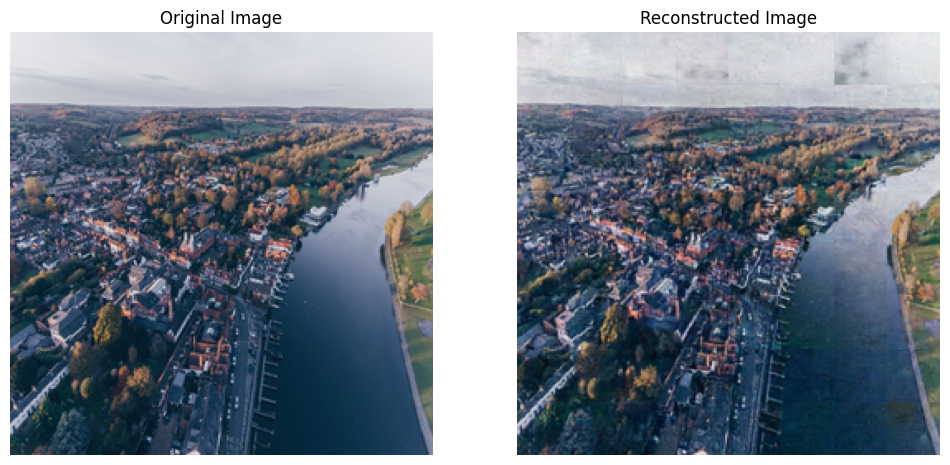

PSNR: 27.46 dB
AWGN SNR = 5
CBR = 1/6


In [98]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Reconstructed Image")
plt.imshow(reconstructed_image)
plt.axis('off')
plt.show()

psnr_value = tf.image.psnr(original_image, reconstructed_image, max_val=255)
print(f"PSNR: {psnr_value.numpy():.2f} dB")

print(f"AWGN SNR = {snr_used}")
print("CBR = 1/6")

Create npz file

In [9]:
image_path = '/kaggle/input/div2k-high-resolution-images/DIV2K_train_HR/DIV2K_train_HR/0037.png'
image = Image.open(image_path).convert('RGB')

# Resize the image to 256x256 
image = image.resize((256, 256), Image.LANCZOS)

original_image = np.array(image)

# Save the image
image.save('resized_image.png')

# Convert to numpy array and rescale to [0, 1]
image = np.array(image) / 255.0

# Break the image into 32x32 patches
patches = tf.image.extract_patches(
    images=tf.expand_dims(image, axis=0),
    sizes=[1, 32, 32, 1],
    strides=[1, 32, 32, 1],
    rates=[1, 1, 1, 1],
    padding='VALID'
)

# Reshape patches to (batch_size, 32, 32, 3)
patches = tf.reshape(patches, (-1, 32, 32, 3))

In [10]:
encoded_data = encoder_network(patches)

In [11]:
def quantize(encoded_data, num_levels):
    min_val = tf.reduce_min(encoded_data)
    max_val = tf.reduce_max(encoded_data)
    quantized_data = tf.round((encoded_data - min_val) / (max_val - min_val) * (num_levels - 1))
    return quantized_data, min_val, max_val

# Example usage
num_levels = 16  # Example: 4-bit quantization
quantized_data, min_val, max_val = quantize(encoded_data, num_levels)


# Function to save the quantized data to a compressed .npz file
def save_encoded_data_to_file(quantized_data, min_val, max_val, file_path):
    np.savez_compressed(file_path, quantized_data=quantized_data.numpy(), min_val=min_val.numpy(), max_val=max_val.numpy())

# Example usage
file_path = "encoded_file.npz"
save_encoded_data_to_file(quantized_data, min_val, max_val, file_path)


In [16]:
# Function to load and decode the quantized data
def load_and_decode(file_path, num_levels):
    with np.load(file_path) as data:
        quantized_data = data['quantized_data']
        min_val = data['min_val']
        max_val = data['max_val']
        
        # Decode the quantized data
        decoded_data = (quantized_data / (num_levels - 1)) * (max_val - min_val) + min_val
    return decoded_data

# Example usage
num_levels = 16  # Should match the quantization level used during encoding
data = load_and_decode("encoded_file.npz", num_levels)

In [12]:
#Lossless

def save_data_lossless(encoded_data, file_path):
    np.savez_compressed(file_path, encoded_data=encoded_data.numpy())

# Example usage
file_path = "encoded_file_lossless.npz"
save_data_lossless(encoded_data, file_path)


def load_data_lossless(file_path):
    with np.load(file_path) as data:
        encoded_data = data['encoded_data']
    return encoded_data

# Example usage
file_path = "encoded_file_lossless.npz"
data = load_data_lossless(file_path)

In [17]:
decoded_data = decoder_network(data)

In [18]:
new_image = imBatchtoImage(decoded_data)

# Post-process reconstructed image (rescale to [0, 255])
new_image = np.clip(new_image * 255, 0, 255).astype(np.uint8)

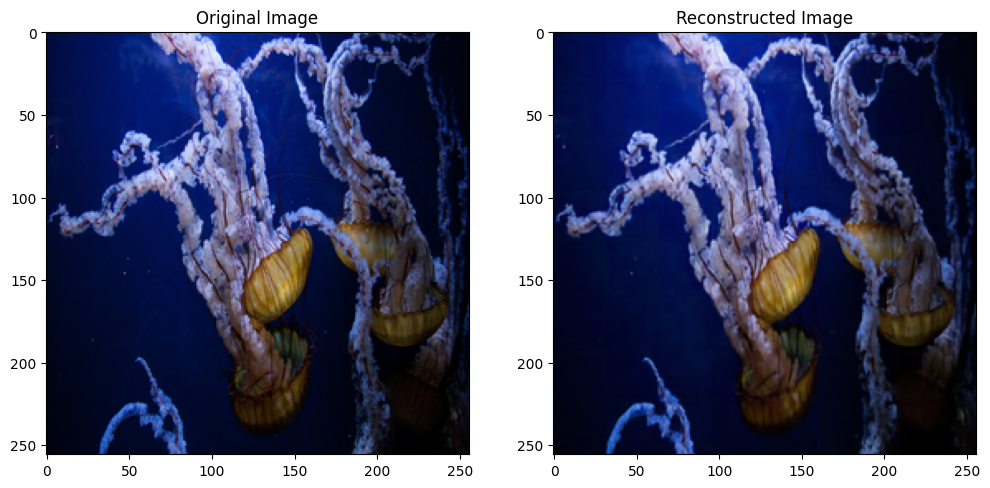

PSNR: 33.56 dB


In [19]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_image)

plt.subplot(1, 2, 2)
plt.title("Reconstructed Image")
plt.imshow(new_image)
plt.show()

psnr_value = tf.image.psnr(original_image, new_image, max_val=255)
print(f"PSNR: {psnr_value.numpy():.2f} dB")